In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *
from numba import njit

plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def extract_beta(inf_coord_path):
    with open(inf_coord_path, "r") as f:
        for line in f.readlines():
            if '- beta_b:' in line:
                b = line.split()[-1]
                return float(b)
            
def extract_true_beta(file_path: str) -> float:
    match = re.search(r'B_bi_(\d+\.?\d*)', file_path)
    if match:
        return float(match.group(1))
    return None

In [5]:
p = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/beta_b/'

res = {}

for i in range(10):
    for d_in in [1, 2, 3, 4]:
        for d_emb in [1, 2, 3, 4]:
            for file in sorted(glob.glob(f"{p}/dim_{d_in}_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.7_N_f_1000_B_bi_*_c_0.0_i_{i}/eS{d_emb}/*.inf_log")):
                res[(d_in, d_emb, i, extract_true_beta(file))] = [extract_beta(file) / d_emb]


In [6]:
df = pd.DataFrame(res).T.reset_index()
df.columns = ['D_in', 'D_emb', 'i', 'true_beta_b', 'inf_beta_b']
df

,D_in,D_emb,i,true_beta_b,inf_beta_b
0,1,1,0,1.3,1.302700
1,1,1,0,1.5,1.471800
2,1,1,0,1.7,1.741300
3,1,1,0,2.2,2.283200
4,1,1,0,2.5,2.396800
...,...,...,...,...,...
1275,4,4,9,2.2,2.281000
1276,4,4,9,2.5,2.838675
1277,4,4,9,2.7,2.699325
1278,4,4,9,2.0,2.078725


In [22]:
colors = [
  "#a00e00",
  "#d04e00",
  "#f6c200",
  "#0086a8",
  "#132b69"
]

def plot_per_dim(df, dim, ax):
    df_tmp = df[df['D_in'] == dim]
    xx = np.linspace(1.1, 3)
    ax.plot(xx, xx, linewidth=1.5, linestyle='--', color='black')
    
    for d_emb in [1, 2, 3, 4]:
        df_current = df_tmp[df_tmp['D_emb'] == d_emb]
        sns.lineplot(data=df_current, x='true_beta_b', y='inf_beta_b', 
                     color=colors[d_emb-1], label=rf'$D_{{out}}={{{d_emb}}}$',                     
                     estimator=np.median,
                    errorbar=('pi', 50),     # 25th–75th percentiles (IQR range)
                    err_style='bars',        # or omit for a band
                     marker='o', linestyle='', ax=ax, legend=False)
    ax.set_title(rf'$D_{{in}}={{{dim}}}$')
    ax.set_ylabel('')
    ax.grid(alpha=0.1)

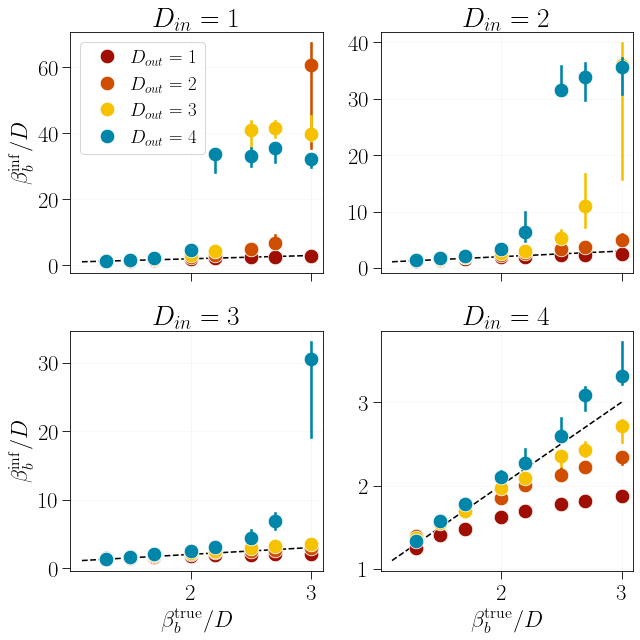

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(9,9), sharex=True)
plot_per_dim(df, 1, ax=axs[0,0])
plot_per_dim(df, 2, ax=axs[0,1])
plot_per_dim(df, 3, ax=axs[1,0])
plot_per_dim(df, 4, ax=axs[1,1])

axs[0,0].set_ylabel(r'$\beta_b^{\mathrm{inf}}/D$')
axs[0,0].legend(handletextpad=0.2)
axs[1,0].set_ylabel(r'$\beta_b^{\mathrm{inf}}/D$')
axs[1,0].set_xlabel(r'$\beta_b^{\mathrm{true}}/D$')
axs[1,1].set_xlabel(r'$\beta_b^{\mathrm{true}}/D$')

plt.tight_layout()
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/true_vs_inf_beta.pdf")
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/SI/plots/true_vs_inf_beta_new.pdf")